# Día 2: Métodos de Análisis y Visualización de Series Temporales

Este notebook cubre las principales técnicas de análisis y visualización para series temporales:
- Media móvil (Moving Average)
- Suavizado exponencial (Exponential Smoothing)
- Autocorrelación (ACF) y Autocorrelación parcial (PACF)
- Descomposición de series temporales

**Objetivos**:
1. Entender qué es y para qué sirve cada técnica.
2. Aprender a implementarlas en Python (pandas, statsmodels, etc.).
3. Aplicarlas sobre un dataset (en este caso, uno sintético, pero se puede adaptar a datos reales).
4. Interpretar los resultados para extraer información sobre la serie.

¡Comencemos!

## Sección 0: Importación de librerías y configuración

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para la descomposición y las funciones de ACF/PACF
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuraciones de estilo
%matplotlib inline
sns.set_style('whitegrid')

print("Librerías importadas y entorno configurado.")


Librerías importadas y entorno configurado.


## Sección 1: Creación (o Carga) del Dataset

Para este ejemplo, crearemos datos sintéticos que simulen:
- Una tendencia creciente.
- Una estacionalidad mensual (aprox. cada 30 días).
- Ruido aleatorio.

Sin embargo, si cuentas con un dataset real, sustituye esta parte por:

In [4]:
# df = pd.read_csv("ruta_a_tus_datos.csv", parse_dates=['columna_fecha'], index_col='columna_fecha')
# df = df.sort_index()  # Asegúrate de tener ordenadas las fechas

In [5]:
# Sección 1: Generación de datos sintéticos

np.random.seed(42)  # semilla para reproducibilidad

# Generamos un rango de fechas diario para un año
date_range = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')
n = len(date_range)

# Creamos componentes:
# Tendencia (lineal)
trend = np.linspace(50, 150, n)  # inicia en 50 y finaliza en 150

# Estacionalidad (mensual ~ 30 días), usando una función seno
seasonality = 10 * np.sin(2 * np.pi * np.arange(n) / 30)

# Ruido
noise = np.random.normal(loc=0, scale=5, size=n)

# Combinación
values = trend + seasonality + noise

# Construimos el DataFrame
df = pd.DataFrame({'consumo': values}, index=date_range)

df.head()


,consumo
2025-01-01,52.483571
2025-01-02,51.662521
2025-01-03,57.855260
2025-01-04,64.317178
2025-01-05,57.359582


Observamos las primeras filas: un índice de fechas y una sola columna `consumo`.

---

## Sección 2: Exploración Inicial

Analizaremos rápidamente la estructura de los datos, sus estadísticas y haremos un plot inicial.

In [6]:
print("Dimensiones del DataFrame:", df.shape)
df.info()

Dimensiones del DataFrame: (365, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2025-01-01 to 2025-12-31
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   consumo  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [7]:
# Estadísticas descriptivas
df.describe()

,consumo
count,365.000000
mean,100.103036
std,30.170793
min,39.249721
25%,75.210662
50%,100.822138
75%,124.647986
max,160.882168


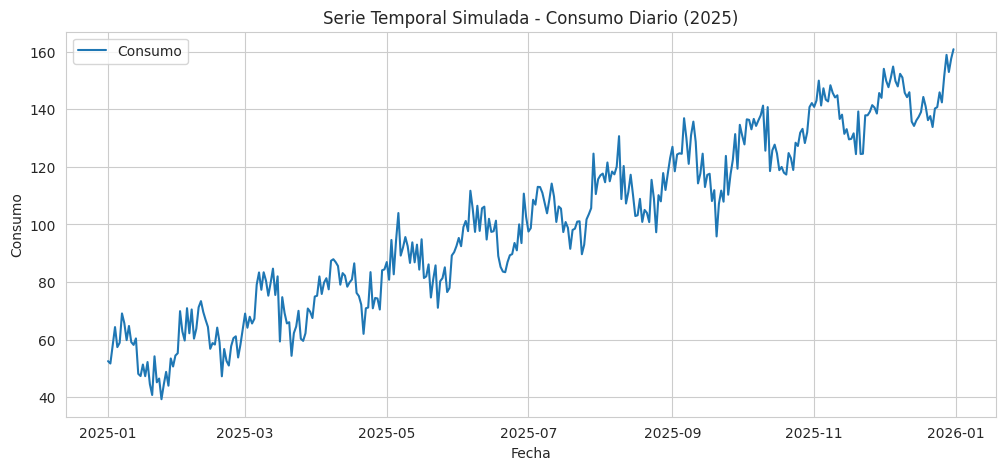

In [8]:
# Visualización inicial de la serie
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['consumo'], label='Consumo')
plt.title('Serie Temporal Simulada - Consumo Diario (2025)')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

**Comentarios**:
- Se aprecia una tendencia creciente (pasa aproximadamente de ~50 a ~150 a lo largo del año).
- Hay fluctuaciones que pueden responder a la parte estacional (ondulaciones) y al ruido aleatorio.

---

## Sección 3: Media Móvil (Moving Average)


La **media móvil** es un método de suavizado que promedia una ventana (ventana deslizante) de datos para cada punto en el tiempo, reduciendo así el ruido y resaltando la tendencia.

### 3.1. Ventana de 7 días (SMA 7)

Probaremos una ventana de 7 días y compararemos la serie original con la suavizada.


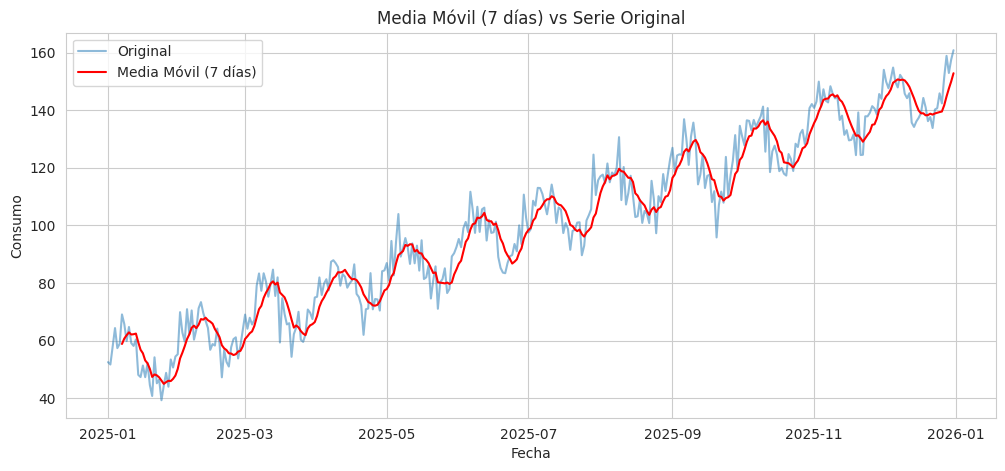

In [9]:
# Sección 3: Media Móvil

df['MA_7'] = df['consumo'].rolling(window=7).mean()  # media móvil de 7 días

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['consumo'], label='Original', alpha=0.5)
plt.plot(df.index, df['MA_7'], label='Media Móvil (7 días)', color='red')
plt.title('Media Móvil (7 días) vs Serie Original')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

**Observa** cómo la línea roja (media móvil) es más suave que la serie original, pues reduce parte de las fluctuaciones diarias.

### 3.2. Experimentando con Ventanas Distintas

¿Qué sucede si usamos una ventana de 30 días?


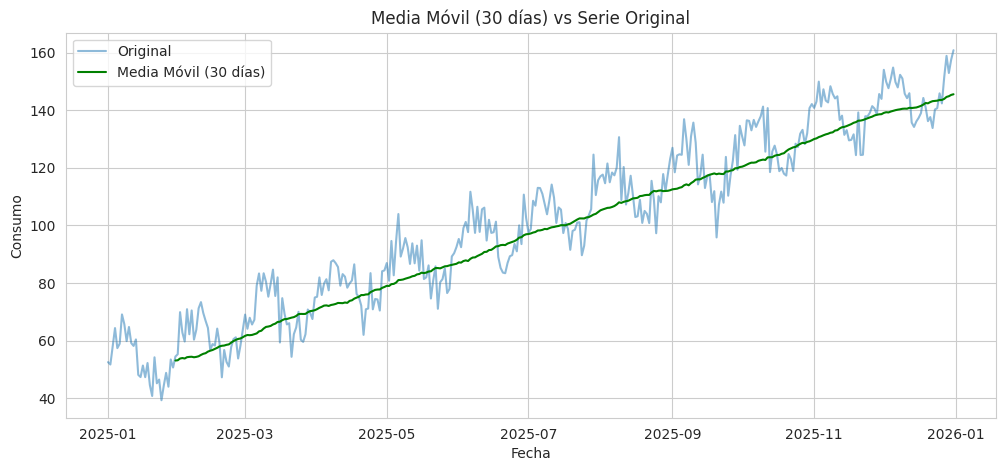

In [10]:
df['MA_30'] = df['consumo'].rolling(window=30).mean()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['consumo'], label='Original', alpha=0.5)
plt.plot(df.index, df['MA_30'], label='Media Móvil (30 días)', color='green')
plt.title('Media Móvil (30 días) vs Serie Original')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

Una ventana de 30 días mostrará una curva aún más suave (se ve mejor la tendencia pero se pierde la granularidad de variaciones más cortas).

---

## Sección 4: Suavizado Exponencial (Exponential Smoothing)

A diferencia de la media móvil simple, el **suavizado exponencial** asigna más peso a los valores más recientes, lo que lo hace más reactivo a cambios súbitos.

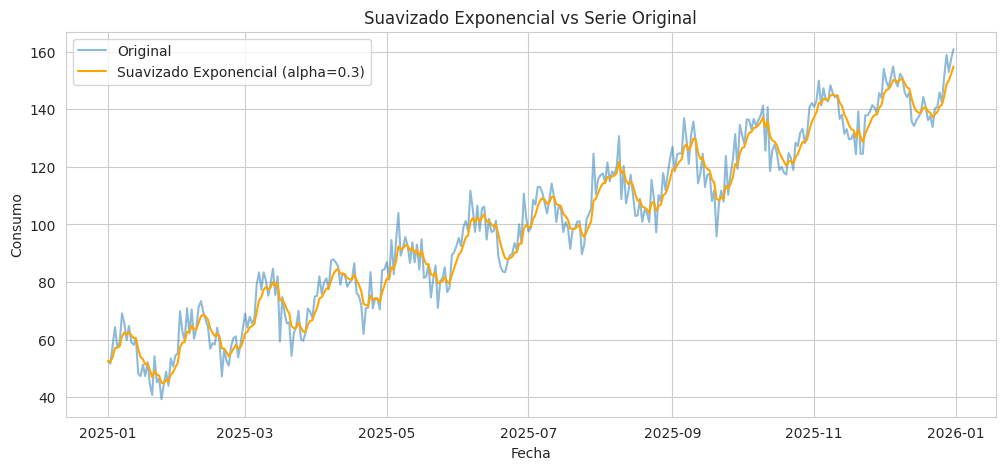

In [11]:
# Sección 4: Suavizado Exponencial

# Usamos el método ewm (Exponentially Weighted Moving)
# alpha es el factor de suavizado (0 < alpha <= 1)
alpha = 0.3
df['EWMA_0.3'] = df['consumo'].ewm(alpha=alpha, adjust=False).mean()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['consumo'], label='Original', alpha=0.5)
plt.plot(df.index, df['EWMA_0.3'], label=f'Suavizado Exponencial (alpha={alpha})', color='orange')
plt.title('Suavizado Exponencial vs Serie Original')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

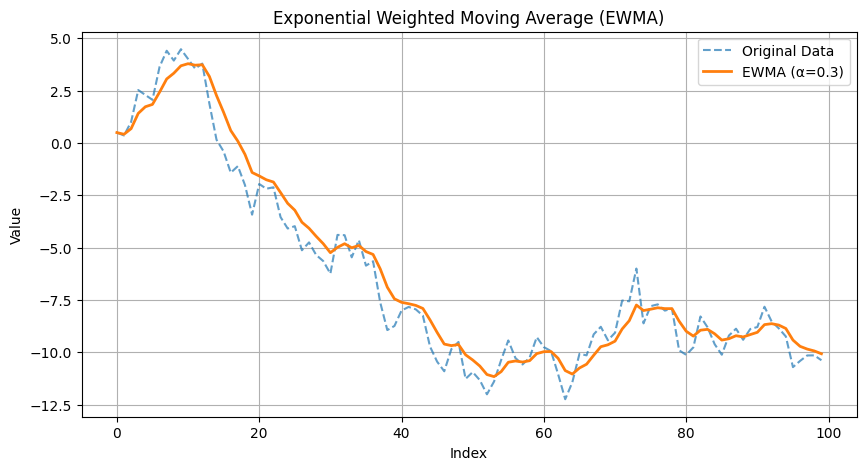

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create a sample dataset
np.random.seed(42)
n = 100
df = pd.DataFrame({'col': np.random.randn(n).cumsum()})  # Simulated time series data

# Apply exponential weighted moving average (EWMA)
df['ewma'] = df['col'].ewm(alpha=0.3).mean()

# Plot the original data and the EWMA
plt.figure(figsize=(10, 5))
plt.plot(df['col'], label='Original Data', linestyle='dashed', alpha=0.7)
plt.plot(df['ewma'], label='EWMA (α=0.3)', linewidth=2)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Exponential Weighted Moving Average (EWMA)')
plt.legend()
plt.grid()
plt.show()


**Comentarios**:
- Cuanto mayor sea `alpha`, más peso se da a las observaciones recientes.  
- Si `alpha` es muy bajo (ej. 0.1), la serie suavizada reacciona lentamente a los cambios.  
- Si `alpha` es más alto (ej. 0.8), el suavizado "sigue" más de cerca la serie original.

---

## Sección 5: Autocorrelación (ACF) y Autocorrelación Parcial (PACF)

El estudio de la **autocorrelación** nos ayuda a ver cómo los valores de la serie en diferentes momentos se relacionan consigo mismos.  
- La **ACF** mide correlación de la serie con sus retardos (lags).  
- La **PACF** mide la autocorrelación parcial, es decir, aislando la influencia de otros retardos intermedios.

Estas herramientas son muy útiles para:
- Identificar estacionalidad (picos en la ACF en lags equivalentes al periodo).
- Determinar órdenes de modelos ARIMA (más avanzado).

### 5.1. Plot ACF

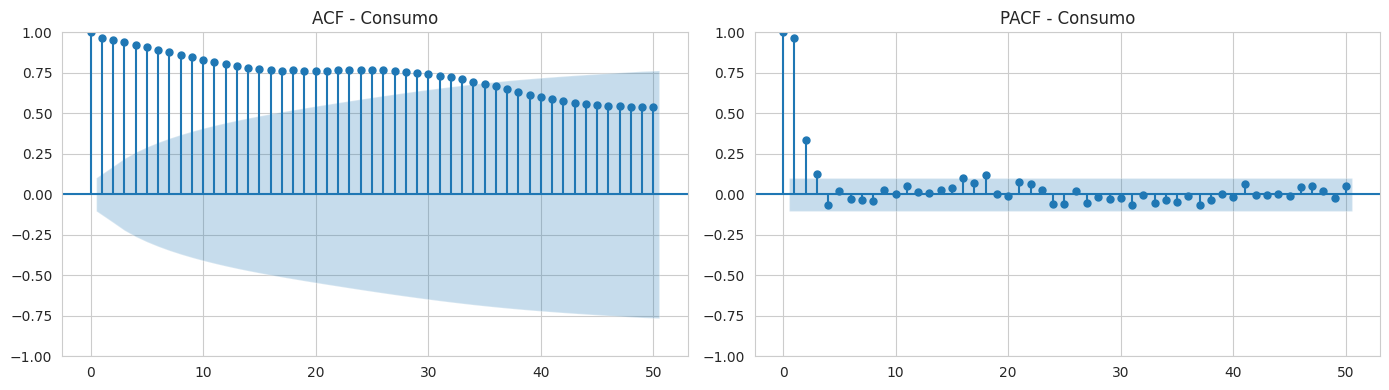

In [12]:
# Sección 5: Autocorrelación

fig, ax = plt.subplots(1,2, figsize=(14, 4))

# ACF
plot_acf(df['consumo'], lags=50, ax=ax[0], title='ACF - Consumo')
# PACF
plot_pacf(df['consumo'], lags=50, ax=ax[1], title='PACF - Consumo', method='ywm')
# method='ywm' es un método recomendado para calculo de PACF

plt.tight_layout()
plt.show()


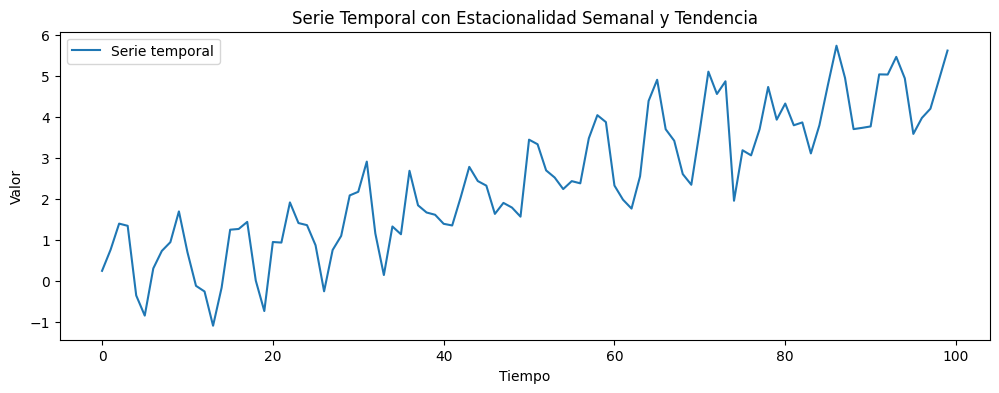

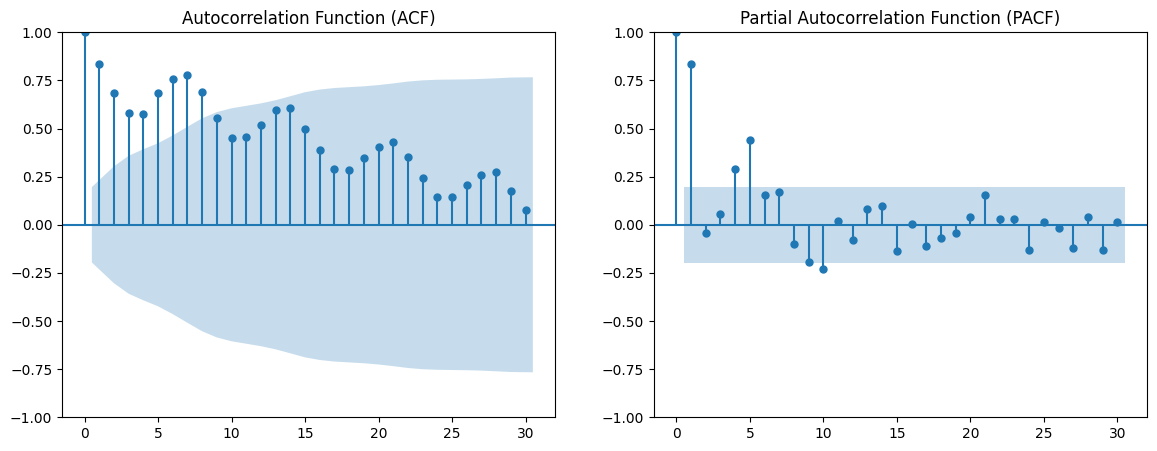

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generar una serie temporal con estacionalidad semanal y una tendencia
np.random.seed(42)
n = 100
t = np.arange(n)
seasonality = np.sin(2 * np.pi * t / 7)  # Estacionalidad semanal
trend = 0.05 * t  # Tendencia lineal
noise = np.random.normal(scale=0.5, size=n)  # Ruido aleatorio
time_series = seasonality + trend + noise

# Crear un DataFrame para mostrar los datos
df = pd.DataFrame({'Time': t, 'Value': time_series})

# Graficar la serie temporal
plt.figure(figsize=(12, 4))
plt.plot(df['Time'], df['Value'], label='Serie temporal')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Serie Temporal con Estacionalidad Semanal y Tendencia')
plt.legend()
plt.show()

# Graficar ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF muestra correlaciones en diferentes rezagos
plot_acf(df['Value'], lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF muestra correlaciones parciales en diferentes rezagos
plot_pacf(df['Value'], lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()


**Interpretación**:
- Busca picos significativos (que sobrepasen las bandas de confianza).  
- Si hay estacionalidad de ~30 días, podríamos ver un pico en `lag=30`.  
- Observa si hay un pico rápido en lag=1 o 2 (posible autocorrelación inmediata).

---


## Sección 6: Descomposición de la Serie (Tendencia, Estacionalidad, Residuo)

La **descomposición** nos permite separar la serie en sus componentes:
- Tendencia (Trend)
- Estacionalidad (Seasonal)
- Residuo (Noise/Random)

`statsmodels` ofrece la función `seasonal_decompose`, donde puedes especificar:
- model='additive' o 'multiplicative'
- period: la estacionalidad aproximada (p.ej. 30 para un ciclo mensual en datos diarios)

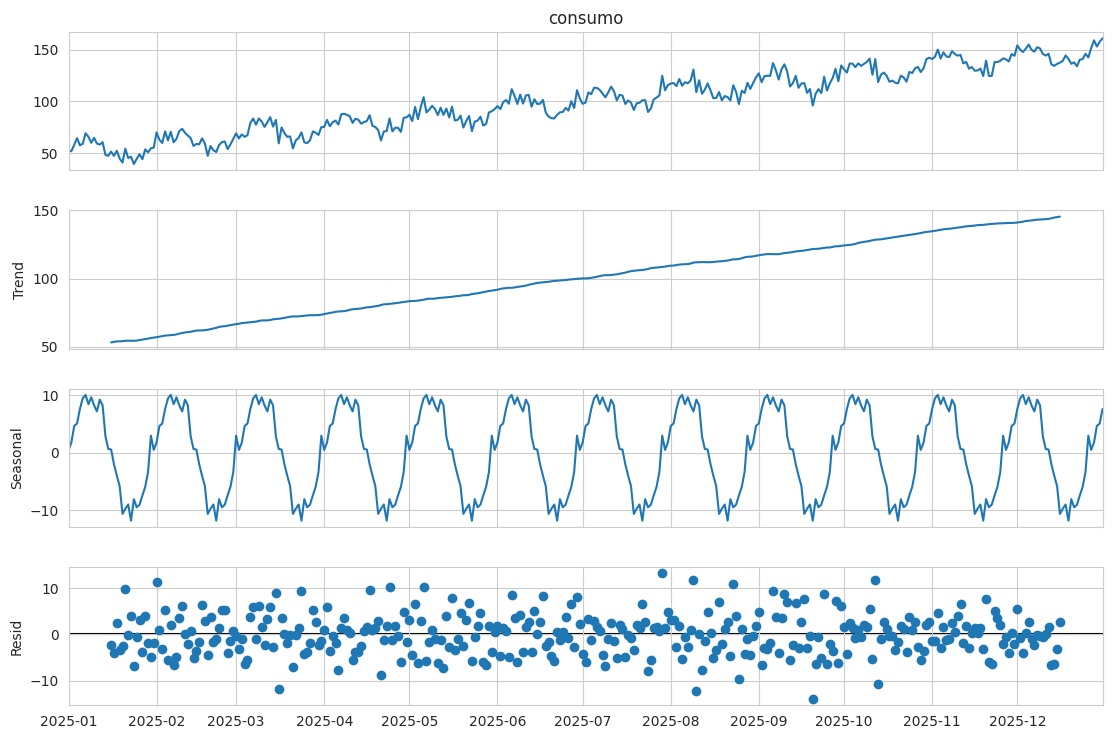

In [13]:
# Sección 6: Descomposición

decompose_result = sm.tsa.seasonal_decompose(df['consumo'], model='additive', period=30)
fig = decompose_result.plot()
fig.set_size_inches(12, 8)
plt.show()


Observamos 4 subgráficos:

1. **Observed**: la serie original.  
2. **Trend**: la tendencia estimada.  
3. **Seasonal**: la estacionalidad aproximada de ~30 días.  
4. **Resid**: el residuo (valores no explicados por tendencia ni estacionalidad).  

La forma de la estacionalidad debería reflejar la onda sinusoidal que creamos. El residuo mostrará el ruido aleatorio.

---


## Sección 7: Conclusiones del Análisis


1. **Media móvil** y **suavizado exponencial** permiten ver la **tendencia** de forma más clara, al reducir la volatilidad de corto plazo.  
2. **ACF** y **PACF** nos permiten identificar posibles patrones de correlación y estacionalidades.  
3. **Descomposición** separa la serie en tendencia, estacionalidad y residuo, facilitando el entendimiento de cada componente.

---

## Sección 8: Tarea (Para los Estudiantes)

1. **Toma el dataset explorado en el Día 1** (real o sintético) y aplica las siguientes técnicas:  
   - Media móvil con diferentes ventanas (7, 14, 30).  
   - Suavizado exponencial con distintos valores de alpha (0.1, 0.3, 0.8).  
2. **Genera** los gráficos ACF y PACF de tu serie y describe si hay picos significativos.  
3. **Descompón** la serie (con `statsmodels`), indicando el periodo que consideres apropiado para su estacionalidad.  
4. **Comenta** tus conclusiones en términos de:
   - ¿Cuál método de suavizado te ayuda más a ver la tendencia?  
   - ¿Tu serie presenta estacionalidad clara según la descomposición y la ACF?  
   - ¿Cómo se ve el residuo?

¡Listo! Con esto concluimos el Notebook del Día 2.

# Fin del Notebook

Has aprendido:
- Cómo **suavizar** la serie mediante media móvil y exponencial.
- Cómo **analizar** la autocorrelación (ACF) y autocorrelación parcial (PACF).
- Cómo **descomponer** la serie en sus componentes principales.

Estos pasos sientan las bases para pasar, en futuras sesiones, a métodos más avanzados de predicción como ARIMA, SARIMA, o modelos basados en ML/Deep Learning.

¡Buen trabajo!
